## Import Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
import PIL
from PIL import Image as PILImage
import io
import ipywidgets as widgets


## Load the Saved Model

In [4]:
# Load the saved model
model_ft = tf.keras.models.load_model('../model/model_ft.h5')

In [9]:
# Dataset paths
TEST_DIR = '../dataset/test'

In [10]:
BATCH_SIZE = 28
IMG_HEIGHT = 224
IMG_WIDTH = 224

## Data Preprocessing

In [11]:
# Rescaling pixel values to [0, 1] for normalization
dataRescale = ImageDataGenerator(rescale=1./255)

# Creating data generator for test dataset
test_dataset_gen = dataRescale.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 320 images belonging to 8 classes.


## Convert Test Generator to TensorFlow Dataset

In [12]:
# Function to convert a generator to a TFDS
def generator_to_tf_dataset(generator):
    return tf.data.Dataset.from_generator(
        lambda: (generator[i] for i in range(len(generator))),
        output_types=(tf.float32, tf.float32), 
        output_shapes=(
            (None, IMG_HEIGHT, IMG_WIDTH, 3),
            (None, len(generator.class_indices)) 
        )
    )

# Converting test dataset to TensorFlow dataset
test_dataset = generator_to_tf_dataset(test_dataset_gen)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

##  Make Predictions on the Test Dataset

In [13]:
# Evaluate the model on the test dataset
predictions = model_ft.predict(test_dataset, verbose=1)

# Convert predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Get true class labels from the test dataset
true_classes = np.concatenate([np.argmax(batch[1], axis=1) for batch in test_dataset])

12/12 [==============================] - 8s 169ms/step


## Classification Report

In [14]:
# Generate and print the classification report
report = classification_report(true_classes, predicted_classes, target_names=list(test_dataset_gen.class_indices.keys()))
print("\nClassification Report:\n", report)


Classification Report:
                        precision    recall  f1-score   support

    Chest Fly Machine       0.82      0.70      0.76        40
             Dumbbell       0.95      0.90      0.92        40
Lat Pull Down Machine       0.76      0.70      0.73        40
Leg Extension Machine       0.97      0.85      0.91        40
    Leg Press Machine       0.94      0.82      0.88        40
   Seated Row Machine       0.69      0.95      0.80        40
        Smith Machine       0.76      0.85      0.80        40
            Treadmill       0.93      0.95      0.94        40

             accuracy                           0.84       320
            macro avg       0.85      0.84      0.84       320
         weighted avg       0.85      0.84      0.84       320



## Confusion Matrix

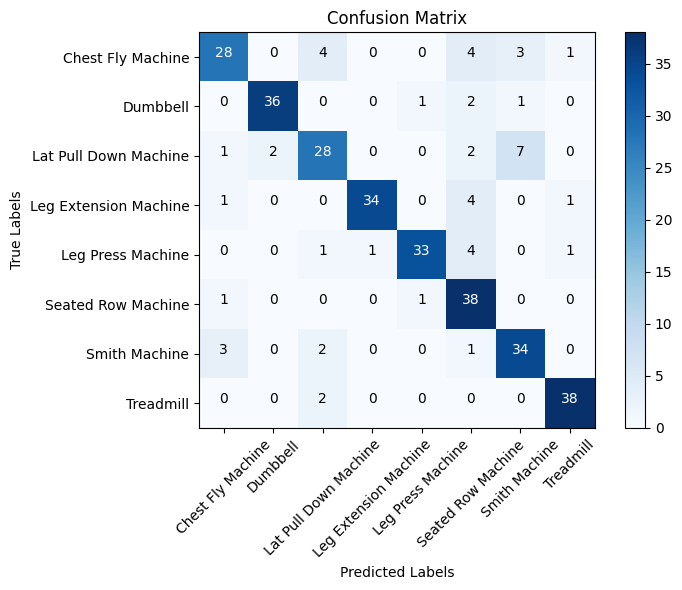

In [15]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Visualize the confusion matrix using matplotlib (heatmap)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(len(test_dataset_gen.class_indices)), list(test_dataset_gen.class_indices.keys()), rotation=45)
plt.yticks(np.arange(len(test_dataset_gen.class_indices)), list(test_dataset_gen.class_indices.keys()))

# Annotate the confusion matrix with the values
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                horizontalalignment="center",
                color="white" if conf_matrix[i, j] > thresh else "black")

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()

##  Test Performance

In [16]:
# Test performance
test_loss, test_accuracy = model_ft.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

12/12 [==============================] - 1s 32ms/step - loss: 0.7797 - accuracy: 0.8406
Test Loss: 0.7797009944915771
Test Accuracy: 0.840624988079071


## Upload Image and Predict Class

FileUpload(value=(), accept='image/*', description='Upload')

1/1 [==============================] - 0s 30ms/step


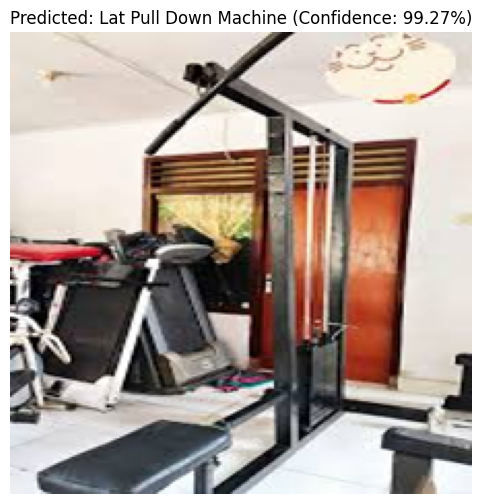

Predicted class: Lat Pull Down Machine
Confidence: 99.27%
1/1 [==============================] - 0s 33ms/step


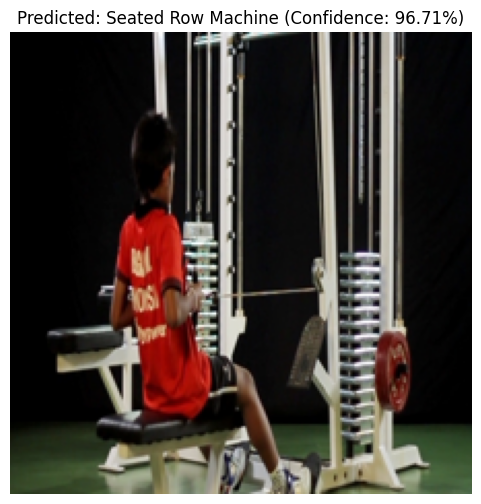

Predicted class: Seated Row Machine
Confidence: 96.71%
1/1 [==============================] - 0s 39ms/step


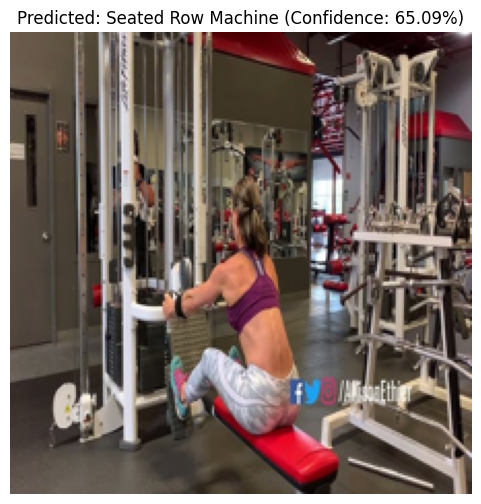

Predicted class: Seated Row Machine
Confidence: 65.09%
1/1 [==============================] - 0s 26ms/step


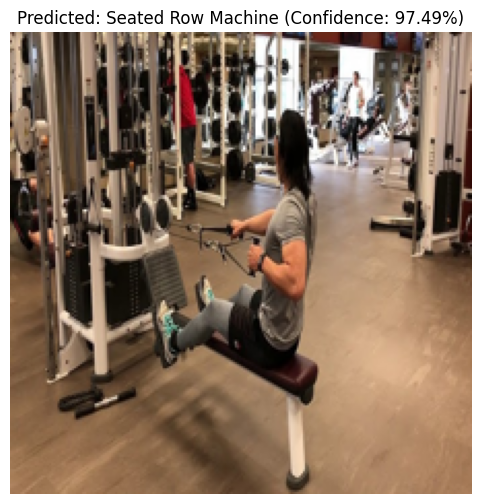

Predicted class: Seated Row Machine
Confidence: 97.49%
1/1 [==============================] - 0s 30ms/step


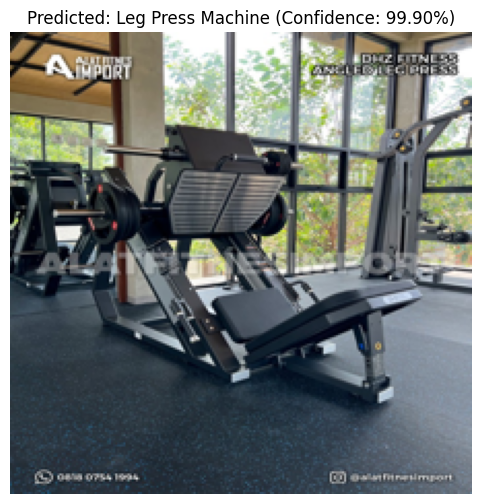

Predicted class: Leg Press Machine
Confidence: 99.90%


In [51]:
# Function to predict and display the class of an image along with confidence
def predict_image_widget(image_data, model, target_size=(IMG_HEIGHT, IMG_WIDTH), confidence_threshold=0.5):
    # Convert the uploaded image data into a PIL Image
    image = PILImage.open(io.BytesIO(image_data))
    
    # Resize the image to match the model's input size
    image_resized = image.resize(target_size)
    
    # Convert the image to a numpy array and normalize
    image_array = img_to_array(image_resized) / 255.0
    
    # Add batch dimension (model expects batch input)
    image_array = np.expand_dims(image_array, axis=0)
    
    # Predict the class of the image
    prediction = model.predict(image_array)
    
    # Get the class with the highest probability
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    confidence = prediction[0][predicted_class_index]
    
    # Map the predicted class index to the class label
    class_label = list(test_dataset_gen.class_indices.keys())[predicted_class_index]
    
    # Check if confidence meets the threshold
    if confidence < confidence_threshold:
        class_label = "Posisikan kamera di depan alat dan pastikan alat terlihat jelas."
        confidence = 0  # Optionally set confidence to 0 or some other indication
    
    # Display the image with predicted class and confidence
    plt.figure(figsize=(6, 6))
    plt.imshow(image_resized)
    plt.title(f"Predicted: {class_label} (Confidence: {confidence * 100:.2f}%)")
    plt.axis('off')
    plt.show()
    
    # Output predicted class and confidence
    print(f"Predicted class: {class_label}")
    print(f"Confidence: {confidence * 100:.2f}%")

# Create an image upload widget
upload_widget = widgets.FileUpload(
    accept='image/*',  # Allow only image files
    multiple=False  # Single file upload
)

# Callback function to handle image upload
def on_upload_change(change):
    uploaded_files = change['new']
    
    if uploaded_files:
        uploaded_file = uploaded_files[0]
        # Check if the file contains 'content'
        if isinstance(uploaded_file, dict) and 'content' in uploaded_file:
            image_data = uploaded_file['content'].tobytes()  # Convert to bytes
            predict_image_widget(image_data, model_ft)  # Call prediction function with the uploaded image

# Link the upload widget to the callback
upload_widget.observe(on_upload_change, names='value')

# Display the upload widget
display(upload_widget)
